<a href="https://colab.research.google.com/github/harrymkwn/InfluenceAnalysis/blob/master/AllEmointGen_Norm_E1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from gensim.models import KeyedVectors
from sklearn.model_selection import train_test_split
from google.colab import  drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
device_name = tf.test.gpu_device_name()
print(device_name)
df = pd.read_csv('/content/drive/MyDrive/InfluenceAnalysis/Emoint/E1.csv')
df = df.sample(frac=1,random_state=32)

Mounted at /content/drive
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/device:GPU:0


In [2]:
print(df.columns)

Index(['Unnamed: 0', 'tweets', 'emotion', 'intensity'], dtype='object')


In [3]:
category_dict = {0:[1,0,0,0],1:[0,1,0,0],2:[0,0,1,0],3:[0,0,0,1]}
data_tweet = [x.lower().split() for x in df['tweets']]
data_cat = np.array([category_dict[x] for x in df['emotion']])

In [4]:
print(data_tweet[:5])
print(data_cat[:5])

[['when', 'my', 'life', 'became', 'such', 'a', 'concern', 'to', 'irrelevant', 'ass', 'people', 'ill', 'never', 'know'], ['in', 'other', 'news', 'my', 'legs', 'hurt', 'running', '5kinmins', 'flatfeet'], ['yo', 'yo', 'yomy', 'name', 'is', 'darthvader', 'ni', 'feel', 'like', 'i', 'need', 'to', 'puff', 'on', 'my', 'inhaler', 'i', 'am', 'no', 'rapper', 'but', 'that', 'was', 'some', 'sick', 'bars', 'breathless', 'bars', 'rap'], ['brb', 'going', 'to', 'sulk', 'in', 'bed', 'until', 'friday'], ['the', 'house', 'no', 'longer', 'echoes', 'with', 'our', 'laughter', 'we', 'light', 'up', 'our', 'memories', 'of', 'the', 'home', 'and', 'sit', 'in', 'the', 'cold', 'waiting', 'amwriting', 'nostalgia']]
[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]]


In [5]:
# Parameters
Min_count = 0
Embedding_size = 200
Window_size = 5
Negative_sampling = 00

In [6]:
w2v_sg = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=1)
w2v_sg.build_vocab(data_tweet)
w2v_sg.train(data_tweet, total_examples=w2v_sg.corpus_count, epochs=5)
w2v_cbow = Word2Vec(min_count=Min_count,
                     window=Window_size,
                     size=Embedding_size,
                     negative=Negative_sampling,sg=0)
w2v_cbow.build_vocab(data_tweet)
w2v_cbow.train(data_tweet, total_examples=w2v_cbow.corpus_count, epochs=5)
w2v_sg.wv.init_sims(True)
w2v_cbow.wv.init_sims(True)

In [7]:
vocab_sg = w2v_sg.wv.vocab
vocab_sg = [x for x in vocab_sg]
vocab_cbow = w2v_cbow.wv.vocab
vocab_cbow = [x for x in vocab_cbow] 
vocab_glove = {}
with open("/content/drive/My Drive/InfluenceAnalysis/glove/glove.twitter.27B.200d.txt", 'r', encoding="utf-8") as f:
  for line in f:
      values = line.split()
      word = values[0]
      vector = np.asarray(values[1:], "float32")
      vocab_glove[word] = vector

In [8]:
print(len(vocab_sg))
print(len(vocab_cbow))


16645
16645


In [9]:
batch_size = 100
Max_input_size = max([len(x) for x in data_tweet])


In [10]:
def vec_gen(w2v,vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([w2v.wv.get_vector(i) for i in x if i in vocab]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)

def glove_gen(vocab,data_tweet,data_cat,batch_size,Max_input_size,Embedding_size):
  while True:
    for k in range(int(len(data_tweet)/batch_size)):
      temp = np.array([np.array([vocab[i] for i in x if i in vocab.keys()]) for x in data_tweet[k*(batch_size):(k+1)*(batch_size)]])
      temp = np.array([np.pad(x.flatten(),(0,Max_input_size*Embedding_size-len(x.flatten()))).reshape(Max_input_size,Embedding_size) for x in temp])
      tempres = data_cat[k*(batch_size):(k+1)*(batch_size)]
      yield (temp,tempres)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_tweet, data_cat, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)
result_table = [0,0,0,0,0,0,0,0,0]

In [12]:
epochs = 60

In [13]:
from keras import backend as K
def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recalls = true_positives / (possible_positives + K.epsilon())
        return recalls
def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precisions = true_positives / (predicted_positives + K.epsilon())
        return precisions
def f1(y_true, y_pred):
    precisions = precision(y_true, y_pred)
    recalls = recall(y_true, y_pred)
    return 2*((precisions*recalls)/(precisions+recalls+K.epsilon()))

In [14]:
model_sg = tf.keras.Sequential()
model_sg.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg.add(tf.keras.layers.LSTM(64))
model_sg.add(tf.keras.layers.Dropout(0.2))
model_sg.add(tf.keras.layers.Dense(64,activation='relu'))
model_sg.add(tf.keras.layers.Dropout(0.2))
model_sg.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
sg_train_gen=vec_gen(w2v_sg,vocab_sg,X_train,y_train,batch_size,Max_input_size,Embedding_size)
sg_val_gen=vec_gen(w2v_sg,vocab_sg,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_sg_lstm = model_sg.fit_generator(sg_train_gen,validation_data=sg_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_sg.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[0]=history[1]
print("SG_LSTM")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 38s 120ms/step - loss: 1.3808 - accuracy: 0.3142 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3695 - val_accuracy: 0.3233 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 5s 105ms/step - loss: 1.3558 - accuracy: 0.3296 - f1: 0.0373 - precision: 0.3926 - recall: 0.0200 - val_loss: 1.3565 - val_accuracy: 0.3442 - val_f1: 0.1508 - val_precision: 0.4801 - val_recall: 0.0908
Epoch 3/60
46/46 [==============================] - 5s 104ms/step - loss: 1.3256 - accuracy: 0.3508 - f1: 0.1398 - precision: 0.6658 - recall: 0.0818 - val_loss: 1.3420 - val_accuracy: 0.3458 - val_f1: 0.1947 - val_precision: 0.5177 - val_recall: 0.1208
Epoch 4/60
46/46 [==============================] - 5s 105ms/step - loss: 1.3045 - accuracy: 0.3734 - f1: 0.1636 - precision: 0.6927 - recall: 0.0961 - val_loss: 1.3355 - val_accuracy: 0.3717 - val_f1: 0.2091 - va

In [15]:
model_sg_bi = tf.keras.Sequential()
model_sg_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_sg_bi.add(tf.keras.layers.Dropout(0.2))
model_sg_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_sg_bi.add(tf.keras.layers.Dropout(0.2))
model_sg_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_sg_bi = model_sg_bi.fit_generator(sg_train_gen,validation_data=sg_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_sg_bi.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[1]=history[1]
print("SG_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 8s 121ms/step - loss: 1.3782 - accuracy: 0.3083 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3606 - val_accuracy: 0.3408 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 5s 106ms/step - loss: 1.3587 - accuracy: 0.3208 - f1: 0.0085 - precision: 0.0865 - recall: 0.0049 - val_loss: 1.3309 - val_accuracy: 0.3558 - val_f1: 0.0115 - val_precision: 0.3750 - val_recall: 0.0058
Epoch 3/60
46/46 [==============================] - 5s 105ms/step - loss: 1.3007 - accuracy: 0.3929 - f1: 0.0811 - precision: 0.5353 - recall: 0.0470 - val_loss: 1.2911 - val_accuracy: 0.4108 - val_f1: 0.1007 - val_precision: 0.6425 - val_recall: 0.0550
Epoch 4/60
46/46 [==============================] - 5s 105ms/step - loss: 1.2317 - accuracy: 0.4653 - f1: 0.1947 - precision: 0.6929 - recall: 0.1168 - val_loss: 1.2686 - val_accuracy: 0.4350 - val_f1: 0.1602 - val

In [16]:
model_sg_rnn = tf.keras.Sequential()
model_sg_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_sg_rnn.add(tf.keras.layers.SimpleRNN(64))
model_sg_rnn.add(tf.keras.layers.Dropout(0.2))
model_sg_rnn.add(tf.keras.layers.Dense(64,activation='relu'))
model_sg_rnn.add(tf.keras.layers.Dropout(0.2))
model_sg_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_sg_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_sg_rnn = model_sg_rnn.fit_generator(sg_train_gen,validation_data=sg_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_sg_rnn.evaluate(x = vec_gen(w2v_sg,vocab_sg,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)


result_table[2]=history[1]
print("SG_RNN")

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


46/46 [==============================] - 7s 126ms/step - loss: 1.3901 - accuracy: 0.2765 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3692 - val_accuracy: 0.3383 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 5s 120ms/step - loss: 1.3635 - accuracy: 0.3224 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3651 - val_accuracy: 0.3233 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
46/46 [==============================] - 6s 121ms/step - loss: 1.3521 - accuracy: 0.3319 - f1: 0.0024 - precision: 0.0897 - recall: 0.0012 - val_loss: 1.3639 - val_accuracy: 0.3208 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/60
46/46 [==============================] - 6s 121ms/step - loss: 1.3272 - accuracy: 0.3697 - f1: 0.0207 - precision: 0.6026 - recall: 0.0106 - val_loss: 1.3498 - val_accuracy: 0.33

In [17]:
model_cbow = tf.keras.Sequential()
model_cbow.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow.add(tf.keras.layers.LSTM(64))
model_cbow.add(tf.keras.layers.Dropout(0.2))
model_cbow.add(tf.keras.layers.Dense(64,activation='relu'))
model_cbow.add(tf.keras.layers.Dropout(0.2))
model_cbow.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
cbow_train_gen=vec_gen(w2v_cbow,vocab_cbow,X_train,y_train,batch_size,Max_input_size,Embedding_size)
cbow_val_gen=vec_gen(w2v_cbow,vocab_cbow,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_cbow_lstm = model_cbow.fit_generator(cbow_train_gen,validation_data=cbow_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_cbow.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[3]=history[1]
print("CBOW_LSTM")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 7s 117ms/step - loss: 1.3813 - accuracy: 0.3200 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3708 - val_accuracy: 0.3233 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 5s 108ms/step - loss: 1.3626 - accuracy: 0.3317 - f1: 0.0196 - precision: 0.1941 - recall: 0.0108 - val_loss: 1.3536 - val_accuracy: 0.3358 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
46/46 [==============================] - 5s 109ms/step - loss: 1.3245 - accuracy: 0.3585 - f1: 0.0940 - precision: 0.6108 - recall: 0.0529 - val_loss: 1.3335 - val_accuracy: 0.3533 - val_f1: 0.0837 - val_precision: 0.6537 - val_recall: 0.0450
Epoch 4/60
46/46 [==============================] - 5s 109ms/step - loss: 1.3074 - accuracy: 0.3656 - f1: 0.1619 - precision: 0.6478 - recall: 0.0936 - val_loss: 1.3240 - val_accuracy: 0.3858 - val_f1: 

In [18]:
model_cbow_bi = tf.keras.Sequential()
model_cbow_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_cbow_bi.add(tf.keras.layers.Dropout(0.2))
model_cbow_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_cbow_bi.add(tf.keras.layers.Dropout(0.2))
model_cbow_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_cbow_bi = model_cbow_bi.fit_generator(cbow_train_gen,validation_data=cbow_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_cbow_bi.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[4]=history[1]
print("CBOW_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


Epoch 1/60
46/46 [==============================] - 8s 124ms/step - loss: 1.3825 - accuracy: 0.2838 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3659 - val_accuracy: 0.3408 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 5s 108ms/step - loss: 1.3661 - accuracy: 0.3167 - f1: 7.6929e-04 - precision: 0.0208 - recall: 3.9688e-04 - val_loss: 1.3358 - val_accuracy: 0.3908 - val_f1: 0.0480 - val_precision: 0.7153 - val_recall: 0.0250
Epoch 3/60
46/46 [==============================] - 5s 109ms/step - loss: 1.3184 - accuracy: 0.3988 - f1: 0.0524 - precision: 0.6365 - recall: 0.0292 - val_loss: 1.2922 - val_accuracy: 0.4217 - val_f1: 0.1180 - val_precision: 0.6095 - val_recall: 0.0658
Epoch 4/60
46/46 [==============================] - 5s 110ms/step - loss: 1.2425 - accuracy: 0.4504 - f1: 0.1761 - precision: 0.7452 - recall: 0.1031 - val_loss: 1.2590 - val_accuracy: 0.4383 - val_f1: 0.17

In [19]:
model_cbow_rnn = tf.keras.Sequential()
model_cbow_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_cbow_rnn.add(tf.keras.layers.SimpleRNN(64))
model_cbow_rnn.add(tf.keras.layers.Dropout(0.2))
model_cbow_rnn.add(tf.keras.layers.Dense(64,activation='relu'))
model_cbow_rnn.add(tf.keras.layers.Dropout(0.2))
model_cbow_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_cbow_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])

history_cbow_rnn = model_cbow_rnn.fit_generator(cbow_train_gen,validation_data=cbow_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_cbow_rnn.evaluate(x = vec_gen(w2v_cbow,vocab_cbow,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[5]=history[1]
print("CBOW_RNN")

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  after removing the cwd from sys.path.


46/46 [==============================] - 7s 129ms/step - loss: 1.3906 - accuracy: 0.2667 - f1: 3.5420e-04 - precision: 0.0179 - recall: 1.7887e-04 - val_loss: 1.3755 - val_accuracy: 0.3008 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 6s 123ms/step - loss: 1.3644 - accuracy: 0.3323 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 1.3789 - val_accuracy: 0.3058 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/60
46/46 [==============================] - 6s 124ms/step - loss: 1.3443 - accuracy: 0.3568 - f1: 0.0022 - precision: 0.0913 - recall: 0.0011 - val_loss: 1.3813 - val_accuracy: 0.2967 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/60
46/46 [==============================] - 6s 123ms/step - loss: 1.3200 - accuracy: 0.3802 - f1: 0.0280 - precision: 0.3892 - recall: 0.0148 - val_loss: 1.3841 - val_accuracy: 0.3008 -

In [20]:
model_glove = tf.keras.Sequential()
model_glove.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_glove.add(tf.keras.layers.LSTM(64))
model_glove.add(tf.keras.layers.Dropout(0.2))
model_glove.add(tf.keras.layers.Dense(64,activation='relu'))
model_glove.add(tf.keras.layers.Dropout(0.2))
model_glove.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
glove_train_gen=glove_gen(vocab_glove,X_train,y_train,batch_size,Max_input_size,Embedding_size)
glove_val_gen=glove_gen(vocab_glove,X_val,y_val,batch_size,Max_input_size,Embedding_size)
history_glove_lstm = model_glove.fit_generator(glove_train_gen,validation_data=glove_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_glove.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[6]=history[1]
print("GLOVE_LSTM")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


Epoch 1/60
46/46 [==============================] - 3s 25ms/step - loss: 1.3796 - accuracy: 0.3045 - f1: 8.1568e-05 - precision: 0.0023 - recall: 4.1731e-05 - val_loss: 1.3000 - val_accuracy: 0.3642 - val_f1: 0.0115 - val_precision: 0.4583 - val_recall: 0.0058
Epoch 2/60
46/46 [==============================] - 1s 14ms/step - loss: 1.2256 - accuracy: 0.4572 - f1: 0.2090 - precision: 0.6578 - recall: 0.1429 - val_loss: 1.0598 - val_accuracy: 0.5583 - val_f1: 0.4897 - val_precision: 0.7206 - val_recall: 0.3725
Epoch 3/60
46/46 [==============================] - 1s 15ms/step - loss: 1.0123 - accuracy: 0.5734 - f1: 0.5088 - precision: 0.7064 - recall: 0.4033 - val_loss: 0.9388 - val_accuracy: 0.5958 - val_f1: 0.5555 - val_precision: 0.7649 - val_recall: 0.4367
Epoch 4/60
46/46 [==============================] - 1s 15ms/step - loss: 0.8739 - accuracy: 0.6374 - f1: 0.5925 - precision: 0.7764 - recall: 0.4817 - val_loss: 0.9215 - val_accuracy: 0.6358 - val_f1: 0.5704 - val_precision: 0.8097 -

In [21]:
model_glove_bi = tf.keras.Sequential()
model_glove_bi.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_glove_bi.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64),merge_mode='concat'))
model_glove_bi.add(tf.keras.layers.Dropout(0.2))
model_glove_bi.add(tf.keras.layers.Dense(64,activation='relu'))
model_glove_bi.add(tf.keras.layers.Dropout(0.2))
model_glove_bi.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_bi.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_glove_bi = model_glove_bi.fit_generator(glove_train_gen,validation_data=glove_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_glove_bi.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[7]=history[1]
print("GLOVE_BI")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


Epoch 1/60
46/46 [==============================] - 4s 30ms/step - loss: 1.3649 - accuracy: 0.3217 - f1: 0.0038 - precision: 0.0792 - recall: 0.0020 - val_loss: 1.2283 - val_accuracy: 0.4633 - val_f1: 0.0709 - val_precision: 0.7313 - val_recall: 0.0375
Epoch 2/60
46/46 [==============================] - 1s 15ms/step - loss: 1.1486 - accuracy: 0.5133 - f1: 0.2931 - precision: 0.6634 - recall: 0.2013 - val_loss: 0.9496 - val_accuracy: 0.6150 - val_f1: 0.5743 - val_precision: 0.7106 - val_recall: 0.4825
Epoch 3/60
46/46 [==============================] - 1s 16ms/step - loss: 0.8815 - accuracy: 0.6491 - f1: 0.6161 - precision: 0.7236 - recall: 0.5372 - val_loss: 0.8275 - val_accuracy: 0.6583 - val_f1: 0.6469 - val_precision: 0.7292 - val_recall: 0.5825
Epoch 4/60
46/46 [==============================] - 1s 15ms/step - loss: 0.7157 - accuracy: 0.7258 - f1: 0.7138 - precision: 0.7966 - recall: 0.6483 - val_loss: 0.8057 - val_accuracy: 0.6658 - val_f1: 0.6596 - val_precision: 0.7235 - val_rec

In [22]:
model_glove_rnn = tf.keras.Sequential()
model_glove_rnn.add(tf.keras.Input(shape=(Max_input_size,Embedding_size)))
model_glove_rnn.add(tf.keras.layers.SimpleRNN(64))
model_glove_rnn.add(tf.keras.layers.Dropout(0.2))
model_glove_rnn.add(tf.keras.layers.Dense(64,activation='relu'))
model_glove_rnn.add(tf.keras.layers.Dropout(0.2))
model_glove_rnn.add(tf.keras.layers.Dense(4, activation='softmax'))
model_glove_rnn.compile(loss='categorical_crossentropy',optimizer='adam', 
                           metrics=['accuracy',f1,precision,recall])
history_glove_rnn = model_glove_rnn.fit_generator(glove_train_gen,validation_data=glove_val_gen,validation_steps=int((len(X_val)/batch_size)+1),steps_per_epoch=int((len(X_train)/batch_size)+1),epochs=epochs)
history = model_glove_rnn.evaluate(x = glove_gen(vocab_glove,X_test,y_test,batch_size,Max_input_size,Embedding_size),steps=int(len(y_test)/batch_size))
print(history)

result_table[8]=history[1]
print("GLOVE_RNN")

Epoch 1/60


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  if sys.path[0] == '':


46/46 [==============================] - 3s 37ms/step - loss: 1.3968 - accuracy: 0.2615 - f1: 7.2491e-04 - precision: 0.0366 - recall: 3.6608e-04 - val_loss: 1.3634 - val_accuracy: 0.3342 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/60
46/46 [==============================] - 1s 33ms/step - loss: 1.3598 - accuracy: 0.3421 - f1: 6.3921e-04 - precision: 0.0093 - recall: 3.4333e-04 - val_loss: 1.3008 - val_accuracy: 0.4025 - val_f1: 0.0431 - val_precision: 0.5645 - val_recall: 0.0225
Epoch 3/60
46/46 [==============================] - 1s 32ms/step - loss: 1.2989 - accuracy: 0.3880 - f1: 0.1157 - precision: 0.5188 - recall: 0.0691 - val_loss: 1.2454 - val_accuracy: 0.4383 - val_f1: 0.3765 - val_precision: 0.5424 - val_recall: 0.2892
Epoch 4/60
46/46 [==============================] - 1s 32ms/step - loss: 1.2005 - accuracy: 0.4774 - f1: 0.2930 - precision: 0.5979 - recall: 0.1979 - val_loss: 1.2264 - val_accuracy: 0.4542 - val_f1: 0.3918 - val_precision:

	Lstm			BiLstm			Rnn
sg [0.5950000286102295, 0.6014285683631897, 0.4000000059604645]
cbow [0.5942857265472412, 0.558571457862854, 0.3807142972946167]
glove [0.802142858505249, 0.7992857098579407, 0.4585714340209961]
{'loss': [1.3748588562011719, 1.352054238319397, 1.286169171333313, 1.2206363677978516, 1.1696046590805054, 1.1260943412780762, 1.0746515989303589, 1.0269455909729004, 0.9888772964477539, 0.9483209252357483, 0.9308350682258606, 0.8956030011177063, 0.8650184869766235, 0.8175415396690369, 0.7761331796646118, 0.7406750321388245, 0.7163100242614746, 0.6676921844482422, 0.6233659386634827, 0.5911402702331543, 0.5877382755279541, 0.561322033405304, 0.5132942795753479, 0.4890585243701935, 0.48337239027023315, 0.4479158818721771, 0.40611642599105835, 0.3676344156265259, 0.33793628215789795, 0.31481704115867615, 0.2907326817512512, 0.2612582743167877, 0.26413872838020325, 0.2417917251586914, 0.23231758177280426, 0.2526080310344696, 0.22815141081809998, 0.2314334213733673, 0.22182896

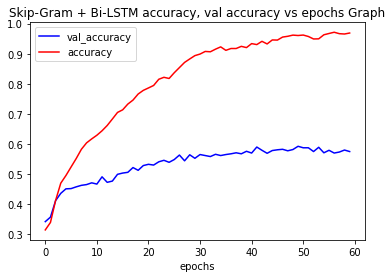

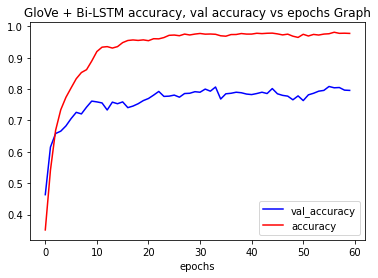

In [23]:
print("\tLstm\t\t\tBiLstm\t\t\tRnn")
print("sg",result_table[:3])
print("cbow",result_table[3:6])
print("glove",result_table[6:9])
print(history_sg_bi.history)
plt.title("Skip-Gram + Bi-LSTM accuracy, val accuracy vs epochs Graph")
plt.plot(history_sg_bi.history['val_accuracy'],c='b',label='val_accuracy')
plt.plot(history_sg_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()
plt.title("GloVe + Bi-LSTM accuracy, val accuracy vs epochs Graph")
plt.plot(history_glove_bi.history['val_accuracy'],c='b',label='val_accuracy')
plt.plot(history_glove_bi.history['accuracy'],c='r',label='accuracy')
plt.xlabel('epochs')
plt.legend()
# plt.yticks()
plt.show()